In [ ]:
import numpy as np
import scipy
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#   COMPUTING THE INTEGRALS IS COSTLY, SO WE TRAIN A NN TO REPRODUCE THE VALUE OF THE INTEGRAL ON SOME POINTS
#   EXPECTING TABLE FORMATTED AS: Temperature mass/Temperature width/Temperature IB IF
#   REFER TO FORMULAE 15 OF 2311.15984
#   THIS SCRIPT IS FOR A NN THAT SHOULD ESTIMATE THE INTEGRAL FOR A GIVEN T m/T AND \gamma/T

table_path = "./table_entropy_large.dat"
table = np.loadtxt(table_path,unpack=True)

table_T = table[0] #GeV
table_moT = table[1]
table_woT = table[2]
table_Ib = table[3] #GeV**3
table_If = table[4] #GeV**3

max_Ib = np.max(table_Ib)
max_If = np.max(table_If)
table_Ib = table_Ib/max_Ib  #Preprocessing: normalizing the integrals in the table. The max values will be used in the DQPMNN so save them!
table_If = table_If/max_If

table_data = np.stack((table_T,table_moT,table_woT),axis=1)

training_set, validation_set, training_label, validation_label = train_test_split(table_data,np.stack((table_Ib,table_If),axis=1),test_size=0.3)

In [ ]:
print(max_Ib, max_If) ######SAVE THESE VALUES! THEY ARE USED IN THE DQPMNN

0.183902 0.132398


In [ ]:
#       NEURAL NET: SURROGATE MODEL FOR THE INTEGRAL CALCULATIONS
#       WE TRAIN THE NN TO REPRODUCE THE INTEGRALS IN THE TABLES
#
#       INPUT: T m/T \gamma/T             OUTPUT: IB  IF


surrogate = tf.keras.Sequential()
surrogate.add( tf.keras.layers.Dense(128,activation='sigmoid') )
surrogate.add( tf.keras.layers.Dense(128,activation='sigmoid') )
surrogate.add( tf.keras.layers.Dense(32,activation='sigmoid') )
surrogate.add( tf.keras.layers.Dense(2,activation='sigmoid') )  #To access the output: I_b = surrogate[:,0]; I_f = surrogate[:,1]

surrogate.build ( input_shape =(None,3) ) #building the model.

@tf.function
def surrogate_loss(data,labels):
        metric = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size') #We use the min of the squared error as metric
        return metric(surrogate(data),labels)

optimizer = tf.optimizers.Adam(0.01)

@tf.function
def surrogate_train(data, labels):
  #training function
  with tf.GradientTape() as gt:
    gt.watch ( surrogate.variables )
    loss_ = surrogate_loss(data,labels)
    grads = gt.gradient (loss_, surrogate.variables)
    optimizer.apply_gradients (zip(grads, surrogate.variables))
    return loss_

surrogate.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 21,218
Trainable params: 21,218
Non-trainable params: 0
_________________________________________________________________


 100% [====================================================================================================>] 
Total loss= 1.5335143429919088e-07  loss validation= 1.5968834306481845e-07


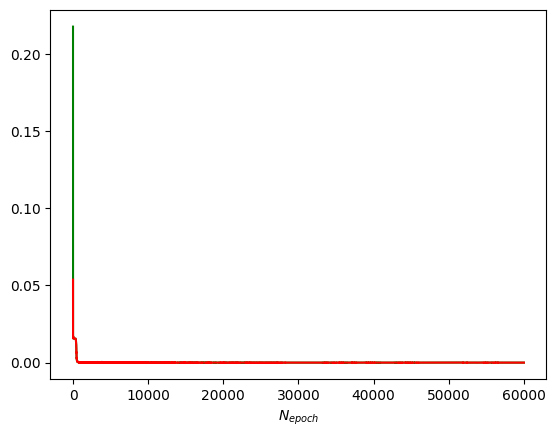

In [ ]:
#In these lists I store the value of the loss function.
loss_train = []
loss_validation=[]

#Training stage
epoch = 60000
for i in range(epoch):
  #training and appending the losses in the lists
  loss_train.append ( surrogate_train(training_set,training_label) )
  loss_validation.append( surrogate_loss(validation_set,validation_label) )
  #the following snippet prints a progress bar for the training
  row = "["+"="*int(100/epoch *(i+1)) + ">"+"."*(int(100-100/epoch *(i+1)))+"]"
  sys.stdout.write("\r %d%% %s " %( int(100/epoch *(i + 1)),row))
  sys.stdout.flush()

sys.stdout.write("\n")

#plot the training and validation losses
plt.subplots()
plt.plot ( loss_train, 'g' )
plt.plot(loss_validation,'r')
plt.xlabel('$N_{epoch}$')

print("Total loss=",loss_train[-1].numpy(),' loss validation=',loss_validation[-1].numpy())

In [1]:
# TEST PLOTS
x = np.linspace(0.155, 0.52, 100)
y=[]
for xi in x:
    y.append(np.array(surrogate(np.reshape([xi,6., 3.38],(1,3))))[0,0])
y=np.array(y)

T_selection = (table_T==0.38)
width_selection = (table_woT==3.38)
mass_selection = (table_moT == 6.)

selection = mass_selection & width_selection

plt.plot(x, y,'b')
plt.xlabel('$T[GeV]$')
plt.plot(table_T[selection],table_Ib[selection],"rd")

plt.show()

In [ ]:
# surrogate.save('../surrogate_entropy.h5')